#SVM

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE

# We load the dataset, select the most relevant features based on previous studies and analysis, select target
df = pd.read_csv("RTA Dataset.csv")

selected_features = [
    'Day_of_week', 'Age_band_of_driver', 'Sex_of_driver', 'Educational_level',
    'Vehicle_driver_relation', 'Driving_experience', 'Type_of_vehicle',
    'Owner_of_vehicle', 'Service_year_of_vehicle', 'Defect_of_vehicle',
    'Area_accident_occured', 'Lanes_or_Medians', 'Road_allignment',
    'Types_of_Junction', 'Road_surface_type', 'Road_surface_conditions',
    'Light_conditions', 'Weather_conditions', 'Type_of_collision',
    'Number_of_vehicles_involved', 'Number_of_casualties',
    'Vehicle_movement', 'Cause_of_accident'
]

target = 'Accident_severity'

In [10]:
# We will deal with the missing data, encode categorical values, feature-target split, apply SMOTE
df = df[selected_features + [target]]
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna('Unknown')
    else:
        df[col] = df[col].fillna(df[col].mean())

label_encoders = {}
for col in df.columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

X = df.drop(target, axis=1)
y = df[target]

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)



Fitting 5 folds for each of 8 candidates, totalling 40 fits

All parameter combinations with F1 and Accuracy:

Params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'} --> Mean F1: 0.7440 | Mean Accuracy: 0.7455
Params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'} --> Mean F1: 0.6015 | Mean Accuracy: 0.6018
Params: {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'} --> Mean F1: 0.7936 | Mean Accuracy: 0.7970
Params: {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'} --> Mean F1: 0.6015 | Mean Accuracy: 0.6018
Params: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'} --> Mean F1: 0.8502 | Mean Accuracy: 0.8519
Params: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'} --> Mean F1: 0.6014 | Mean Accuracy: 0.6017
Params: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'} --> Mean F1: 0.8999 | Mean Accuracy: 0.9003
Params: {'C': 1, 'gamma': 0.1, 'kernel': 'linear'} --> Mean F1: 0.6014 | Mean Accuracy: 0.6017

Best Model Evaluation:
              precision    recall  f1-score     support
0              0.982047  0.998079  0.

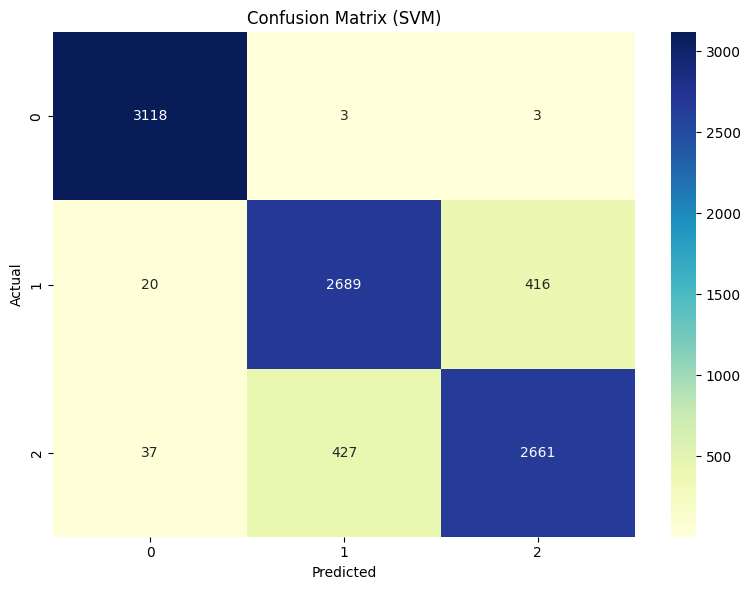

In [12]:
# Now do the train-test split, scale features
X_train, X_test, y_train, y_test = train_test_split(
    X_smote, y_smote, test_size=0.3, random_state=42, stratify=y_smote)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SVM parameter grid & Grid Search
param_grid = {
    'C': [0.1, 1],
    'gamma': ['scale', 0.1],
    'kernel': ['rbf', 'linear']
}
svc = SVC()
grid_search = GridSearchCV(
    svc, param_grid,
    cv=StratifiedKFold(n_splits=5),
    scoring='f1_macro',
    return_train_score=True,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

print("\nAll parameter combinations with F1 and Accuracy:\n")         # To print F1 and accuracy for each configuration
for i, params in enumerate(grid_search.cv_results_['params']):
    f1 = grid_search.cv_results_['mean_test_score'][i]
    model = SVC(**params)
    acc = cross_val_score(model, X_train_scaled, y_train, scoring='accuracy', cv=StratifiedKFold(n_splits=5)).mean()
    print(f"Params: {params} --> Mean F1: {f1:.4f} | Mean Accuracy: {acc:.4f}")

# We evaluate best model & print the classification report
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
print("\nBest Model Evaluation:")
print(report_df)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=label_encoders[target].classes_,
            yticklabels=label_encoders[target].classes_)
plt.title("Confusion Matrix (SVM)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

